In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from utils.customloader import CustomDataset, DatasetSplit
from utils.separate_into_classes import separate_into_classes
from utils.arguments import Args
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar
from models.Fed import FedAvg
from models.test import test_img
from utils.smooth_crossentropy import SmoothCrossEntropyLoss
from utils.dataloader import get_dataloader, set_seed
import random
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import copy
from sklearn.model_selection import train_test_split





In [2]:
from train_glob import main

In [3]:
main()

(30000, 1, 28, 28)
torch.Size([30000])
(30000, 1, 28, 28)
torch.Size([30000])
Train Epoch: 0 [0/30000 (0%)]	Loss: 2.348456

Train loss: 2.306430689493815

Test set: Average loss: 0.00226 
Accuracy: 1493/10000 (14.93%)

Train Epoch: 1 [0/30000 (0%)]	Loss: 2.268748

Train loss: 2.247836192448934

Test set: Average loss: 0.00218 
Accuracy: 3681/10000 (36.81%)

Train Epoch: 2 [0/30000 (0%)]	Loss: 2.210516

Train loss: 2.142793337504069

Test set: Average loss: 0.00196 
Accuracy: 5032/10000 (50.32%)

Train Epoch: 3 [0/30000 (0%)]	Loss: 2.055670

Train loss: 1.9120877504348754

Test set: Average loss: 0.00156 
Accuracy: 6293/10000 (62.93%)

Train Epoch: 4 [0/30000 (0%)]	Loss: 1.738179

Train loss: 1.6306919535001119

Test set: Average loss: 0.00117 
Accuracy: 7517/10000 (75.17%)



In [4]:
args = Args()    

#torch.cuda.is_available()

#set_seed(args.seed)
global_train_loader, local_train_loader, test_loader = get_dataloader(data='mnist', 
                                                                      test_size=0.5, 
                                                                      num_workers=8,
                                                                      batch_size=1000, 
                                                                      seed=args.seed,
                                                                     )



(30000, 1, 28, 28)
torch.Size([30000])
(30000, 1, 28, 28)
torch.Size([30000])


In [5]:
net_glob = CNNMnist(args=args).to(args.device)
net_glob.train()

CNNMnist(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [6]:
loss_train = []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []
total_acc = []

In [7]:
# training
optimizer = optim.SGD(net_glob.parameters(), lr=args.lr, momentum=args.momentum)
sloss = F.cross_entropy
#sloss = SmoothCrossEntropyLoss(smoothing=0.3)


In [8]:
def global_train_epoch(epoch, net_glob, global_train_loader, sloss, optimizer):    
    net_glob.train()
    batch_loss = []
    for batch_idx,(data, target) in enumerate(global_train_loader):
        data, target = data.to(args.device), target.to(args.device)
        optimizer.zero_grad()
        output = net_glob(data)
        loss = sloss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(global_train_loader.dataset),
                       100. * batch_idx / len(global_train_loader), loss.item()))
        batch_loss.append(loss.item())
    loss_avg = sum(batch_loss)/len(batch_loss)
    print('\nTrain loss:', loss_avg)
    
    return net_glob, loss_avg

In [9]:
def test_model(net_glob, test_loader, sloss):
    net_glob.eval()
    test_loss = 0
    correct = 0
    l = len(test_loader)
    for idx, (data, target) in enumerate(test_loader):
        data, target = data.to(args.device), target.to(args.device)
        log_probs = net_glob(data)
        test_loss += F.cross_entropy(log_probs, target).item()
        y_pred = log_probs.data.max(1, keepdim=True)[1]
        correct += y_pred.eq(target.data.view_as(y_pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)

    #After fedlearning
    #print('After Federated Learning')
    print('\nTest set: Average loss: {:.5f} \nAccuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    
    

In [ ]:
list_loss = []
net_glob.train()
for epoch in range(args.epochs):
    net_glob, loss_avg = global_train_epoch(epoch, net_glob, global_train_loader, sloss, optimizer)
    list_loss.append(loss_avg)

    test_model(net_glob, test_loader, sloss)

# Test model after training on global data

In [ ]:
path_checkpoint='./test'
torch.save(net_glob.state_dict(), path_checkpoint)
#Before fedlearning
print('Before Federated Learning')
test_model(net_glob, test_loader, sloss)

In [8]:

#Before fedlearning
path_checkpoint='./test'

net_glob.load_state_dict(torch.load(path_checkpoint))
print('Before Federated Learning')
#test_model(net_glob, test_loader, sloss)


Before Federated Learning


In [10]:
checkpoint_globalnet = copy.deepcopy(net_glob)

# Train local models and update global model

In [11]:
#Ensamble at the end!!

#Keep track of each sub-model and when validating, 
#Calculate the loss for each class
#save the model with the lowest loss for each class as a separate file

#Ensable with Global model and local model


#Keep the original, verify with 


In [12]:
dict_users = mnist_iid(global_train_loader.dataset.data, args.num_users)
len(dict_users[1])

3000

In [13]:
unique, counts = np.unique(global_train_loader.dataset.targets, return_counts=True)
print(unique)
print(counts)
sorted_y = copy.deepcopy(global_train_loader.dataset.targets)
sorted_index_y = np.argsort(np.squeeze(sorted_y))

class_dist=[]

for i in range(args.num_classes):
    print(i)
    class_dist.append(np.array(sorted_index_y[sum(counts[:i]):sum(counts[:i+1])], dtype=np.int64))
    
non_iid = np.array(class_dist)

[0 1 2 3 4 5 6 7 8 9]
[2961 3371 2979 3066 2921 2711 2959 3132 2926 2974]
0
1
2
3
4
5
6
7
8
9


In [14]:
individual = []
for j in range(10):
    individual.append(np.array_split(class_dist[j], 10))

user_dist=[]
for i in range(10):
    temp=[]
    for j in range(10):
        temp.append(individual[j][i])
        
    
    user_dist.append((np.concatenate(temp)).astype(np.int64))    
    
iid=np.array(user_dist)

In [15]:
#Test data loader
#local_dataset = CustomDataset(local_x, local_y, transform=transform)
#ldr_train = DataLoader(DatasetSplit(local_dataset, class_dist[1]), batch_size=args.local_bs, shuffle=True)
#for x,y in ldr_train:
    #x=np.squeeze(np.transpose(x, (0,2,3,1)))
    #break

In [16]:
w_glob = net_glob.state_dict()
w_locals = [w_glob for i in range(args.num_users)]
#local_dataset = CustomDataset(local_x, local_y, transform=transform)

In [17]:
def multi_train_local(q_l, q_w, idx, loss, model):
    
    #print("asdf11")
    
    local = LocalUpdate(args=args, user_num=idx, loss_func=loss, dataset=local_train_loader.dataset, idxs=non_iid[idx])
    
    #print("asdf22")
    print("asdf33")
    w, loss = local.train(net=model.to(args.device))
    
    #print("asdf44")
    
    #lock.acquire()
    q_l.put(loss)
    q_w.put(w)
    #lock.release()
    
    time.sleep(10)
    
    
    #return w, loss
    #w_locals.append(copy.deepcopy(w))
    #loss_locals.append(copy.deepcopy(loss))

In [18]:
def multi_train_local22(q, idx):
    print("user: "+str(idx))
    q.put("asdfasdfasdf") 

In [23]:
#from torch.multiprocessing import Lock

In [1]:
#import torch.multiprocessing as mp
#from torch.multiprocessing import Pool, Process, set_start_method, Queue
from multiprocessing import Pool, Process, set_start_method, Queue
import multiprocessing as mp
import time
from utils.multiprocessing import work



if __name__ == '__main__':
    

    #torch.set_num_threads(1)
    
    set_start_method('spawn', force=True)
    #ctx = mp.get_context('spawn')

    loss_locals=[]
    q_l = Queue()

    procs=[]

    p = Process(target=work, args=(0, q_l))
    p.start()
    p.join()
        
        
        #w_locals.append(q_w.get())
    

In [2]:
print(q_l.get(p))

asdfasdfasdf


In [24]:
def p(non_iid):
    print(non_iid[0])
    return

In [38]:
np.array(non_iid[0]).shape

(2961,)

In [37]:
non_iid[0]

tensor([ 7370, 26615, 26614,  ..., 23367, 15371,  4610])

In [19]:
from utils.multiprocessing import work, multi_train_local_dif
from torch.utils.data.sampler import Sampler
from torchvision import datasets, transforms
import torch.multiprocessing as mp

In [20]:



if __name__ == '__main__':
    
    # training
    mp.set_start_method('spawn', force=True)
    sloss2 = F.cross_entropy
    #sloss2 = SmoothCrossEntropyLoss(smoothing=0.3)

    torch.set_num_threads(1)
    
    #set_start_method('spawn', force=True)
    #ctx = mp.get_context('spawn')

    loss_locals=[]
    w_locals=[]
    procs=[]
    
    
    net_glob.share_memory()
    
    q_l = mp.Queue()
    q_w = mp.Queue()
    #l = Lock()
    
    procs=[]
    
    for i in range(5):

        p = mp.Process(target=multi_train_local_dif, args=(q_l, q_w, args, i, sloss2, local_train_loader, non_iid, net_glob))
        procs.append(p)
        p.start()

    
    for p in procs:
        p.join()
        #




asdf11
asdf11
ye: 0
ye: 1
ye22: [ 7370 26615 26614 ... 23367 15371  4610]
asdf11
ye22: [21808  4826 15174 ...  9455 11518  3440]
ye: 2
asdf22
asdf11
ye22: [11011 12102  7682 ... 20523  5095  5716]
asdf22
ye: 3
11
11
asdf22
asdf11
ye22: [12493 12382 27569 ...   657  4583  6277]
ye: 4
asdf22
11
ye22: [ 1038 15847 28823 ... 23042  9676 29527]
11
asdf22
11


Process Process-82:
Process Process-81:
Traceback (most recent call last):
  File "/home/imtl/.conda/envs/imtl/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Process Process-83:
  File "/home/imtl/.conda/envs/imtl/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/imtl/.conda/envs/imtl/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/imtl/!  personal projects/federated learning/federated-learning/utils/multiprocessing.py", line 25, in multi_train_local_dif
    w, loss = local.train(net=model.to(arguemnts.device))
  File "/home/imtl/.conda/envs/imtl/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/imtl/!  personal projects/federated learning/federated-learning/models/Update.py", line 65, in train
    loss.backward()
  File "/home/imtl

In [24]:
from utils.multiprocessing import work, multi_train_local_dif


In [25]:
import multiprocessing as mp
from multiprocessing import Pool, Process, set_start_method, Queue
import time


if __name__ == '__main__':
    
    # training
    #optimizer2 = optim.SGD(net_glob.parameters(), lr=args.lr, momentum=args.momentum)
    #optimizer2.zero_grad()
    sloss2 = F.cross_entropy
    #sloss2 = SmoothCrossEntropyLoss(smoothing=0.3)

    torch.set_num_threads(1)
    
    set_start_method('spawn', force=True)
    #ctx = mp.get_context('spawn')

    loss_locals=[]
    w_locals=[]
    procs=[]
    
    
    net_glob.share_memory()
    
    q_l = Queue()
    q_w = Queue()
    #l = Lock()
    
    procs=[]
    
    for i in range(2):

        checkpoint_globalnet11 = copy.deepcopy(net_glob)
        checkpoint_globalnet11.share_memory()        
        p = Process(target=multi_train_local_dif, args=(q_l, q_w, args, i, sloss2, local_train_loader, non_iid, checkpoint_globalnet11))
        procs.append(p)
        p.start()
    
        
    #




In [ ]:
while not q_l.empty():
    loss_locals.append(q_l.get())
    
while not q_w.empty():    
    w_locals.append(q_w.get())

In [27]:
for proc in procs:
    proc.join()

In [28]:
loss_locals

[0.012599757862104094, 0.01322289594283547]

In [22]:
checkpoint_globalnet22 = copy.deepcopy(net_glob)

checkpoint_globalnet22.train()
loss_locals = []
w_locals = []
for idx in range(args.num_users):


    local = LocalUpdate(args=args, user_num=idx, loss_func=sloss, dataset=local_train_loader.dataset, idxs=non_iid[idx])
    w, loss = local.train(net=copy.deepcopy(checkpoint_globalnet22).to(args.device))
    w_locals.append(copy.deepcopy(w))
    loss_locals.append(copy.deepcopy(loss))

w_glob = FedAvg(w_locals)
checkpoint_globalnet22.load_state_dict(w_glob)
loss_avg = sum(loss_locals) / len(loss_locals)
print('Round {:3d}, Average loss {:.3f}'.format(iter, loss_avg))

test_model(checkpoint_globalnet22, test_loader, sloss)


11
Local user 0 -- Update Epoch: 0 [0/2961 (0%)]	Loss: 1.855603
Local user 0 -- Update Epoch: 0 [100/2961 (3%)]	Loss: 1.603838
Local user 0 -- Update Epoch: 0 [200/2961 (7%)]	Loss: 1.384777
Local user 0 -- Update Epoch: 0 [300/2961 (10%)]	Loss: 1.463539
Local user 0 -- Update Epoch: 0 [400/2961 (13%)]	Loss: 1.503450
Local user 0 -- Update Epoch: 0 [500/2961 (17%)]	Loss: 1.387912
Local user 0 -- Update Epoch: 0 [600/2961 (20%)]	Loss: 1.429173
Local user 0 -- Update Epoch: 0 [700/2961 (24%)]	Loss: 1.405012
Local user 0 -- Update Epoch: 0 [800/2961 (27%)]	Loss: 1.364068
Local user 0 -- Update Epoch: 0 [900/2961 (30%)]	Loss: 1.419612
Local user 0 -- Update Epoch: 0 [1000/2961 (34%)]	Loss: 1.369678
Local user 0 -- Update Epoch: 0 [1100/2961 (37%)]	Loss: 1.424651
Local user 0 -- Update Epoch: 0 [1200/2961 (40%)]	Loss: 1.397029
Local user 0 -- Update Epoch: 0 [1300/2961 (44%)]	Loss: 1.404231
Local user 0 -- Update Epoch: 0 [1400/2961 (47%)]	Loss: 1.361458
Local user 0 -- Update Epoch: 0 [1500

TypeError: unsupported format string passed to builtin_function_or_method.__format__

In [29]:
test_model(checkpoint_globalnet22, test_loader, sloss)



Test set: Average loss: 0.00230 
Accuracy: 1365/10000 (13.65%)



In [25]:
for iter in range(args.epochs):
    net_glob.train()
    loss_locals = []
    w_locals = []
    #m = max(int(args.frac * args.num_users), 1)
    #idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    
    for idx in range(args.num_users):

        
        local = LocalUpdate(args=args, user_num=idx, loss_func=sloss, dataset=local_train_loader.dataset, idxs=non_iid[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
    
    w_glob = FedAvg(w_locals)
    net_glob.load_state_dict(w_glob)
    loss_avg = sum(loss_locals) / len(loss_locals)
    print('Round {:3d}, Average loss {:.3f}'.format(iter, loss_avg))
    
    test_model(net_glob, test_loader, sloss)

11
Local user 0 -- Update Epoch: 0 [0/2961 (0%)]	Loss: 2.062182
Local user 0 -- Update Epoch: 0 [100/2961 (3%)]	Loss: 0.210519
Local user 0 -- Update Epoch: 0 [200/2961 (7%)]	Loss: 0.002557
Local user 0 -- Update Epoch: 0 [300/2961 (10%)]	Loss: 0.024340
Local user 0 -- Update Epoch: 0 [400/2961 (13%)]	Loss: 0.089091
Local user 0 -- Update Epoch: 0 [500/2961 (17%)]	Loss: 0.000027
Local user 0 -- Update Epoch: 0 [600/2961 (20%)]	Loss: 0.044405
Local user 0 -- Update Epoch: 0 [700/2961 (24%)]	Loss: 0.002056
Local user 0 -- Update Epoch: 0 [800/2961 (27%)]	Loss: 0.001303
Local user 0 -- Update Epoch: 0 [900/2961 (30%)]	Loss: 0.000543
Local user 0 -- Update Epoch: 0 [1000/2961 (34%)]	Loss: 0.002419
Local user 0 -- Update Epoch: 0 [1100/2961 (37%)]	Loss: 0.000297
Local user 0 -- Update Epoch: 0 [1200/2961 (40%)]	Loss: 0.000001
Local user 0 -- Update Epoch: 0 [1300/2961 (44%)]	Loss: 0.001437
Local user 0 -- Update Epoch: 0 [1400/2961 (47%)]	Loss: 0.000051
Local user 0 -- Update Epoch: 0 [1500

KeyboardInterrupt: 

# Test Model on local data

In [35]:
#After fedlearning
print('After Federated Learning -- checkpoint')
test_model(checkpoint_globalnet, test_loader, sloss)

After Federated Learning -- checkpoint

Test set: Average loss: 0.01016 
Accuracy: 9647/10000 (96.47%)



In [33]:
#After fedlearning
print('After Federated Learning')
test_model(net_glob, test_loader, sloss)

After Federated Learning

Test set: Average loss: 0.02773 
Accuracy: 9574/10000 (95.74%)



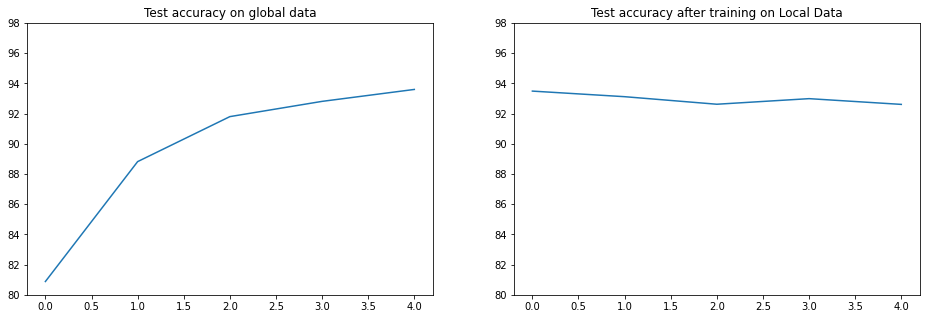

In [21]:
# plot acc curve
f, axarr = plt.subplots(1,2, figsize=(16,5))
axarr[0].plot(range(len(total_acc))[:args.epochs], total_acc[:args.epochs])
axarr[0].set_title('Test accuracy on global data')
#axarr[0].set_xlim([80, 98])
axarr[0].set_ylim([80, 98])
axarr[1].plot(range(len(total_acc))[:args.epochs], total_acc[args.epochs:])
axarr[1].set_title('Test accuracy after training on Local Data')
#axarr[1].set_xlim([80, 98])
axarr[1].set_ylim([80, 98])


plt.show()